In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import json
from torch.autograd import Variable
from torch.distributions import Categorical
from utils.qf_data import normalize,load_observations
from tools.ddpg.replay_buffer import ReplayBuffer
from tools.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
import tensorflow as tf
from tensorboardX import SummaryWriter

In [38]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
C_CUDA = torch.cuda.is_available()

def obs_normalizer(observation):
    # Normalize the observation into close/open ratio
    if isinstance(observation, tuple):
        observation = observation[0]
    
    observation = observation[:, :, 3:4] / observation[:, :, 0:1]
    observation = normalize(observation)
    return observation

In [39]:
# Define actor network--CNN
class Actor(nn.Module):
    def __init__(self,product_num, win_size):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels =  1,
            out_channels = 32,
            kernel_size = (1,3),
            #stride = (1,3)
        )
        self.conv2 = nn.Conv2d(
            in_channels = 32,
            out_channels = 32,
            kernel_size = (1, win_size-2),
            #stride = (1, win_size-2)
        )
        self.linear1 = nn.Linear((product_num + 1)*1*32, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64,product_num + 1)
    
    def reset_parameters(self):
        self.linear1.weight.data.uniform_(*hidden_init(self.linear1))
        self.linear2.weight.data.uniform_(*hidden_init(self.linear2))
        self.linear3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        conv1_out = self.conv1(state)
        conv1_out = F.relu(conv1_out)
        conv2_out = self.conv2(conv1_out)
        conv2_out = F.relu(conv2_out)
        # Flatten
        conv2_out = conv2_out.view(conv2_out.size(0), -1)
        fc1_out = self.linear1(conv2_out)
        fc1_out = F.relu(fc1_out)
        fc2_out = self.linear2(fc1_out)
        fc2_out = F.relu(fc2_out)
        fc3_out = self.linear3(fc2_out)
        fc3_out = F.softmax(fc3_out,dim=1)
        
        return fc3_out

In [40]:
# Define policy gradient actor network--LSTM
class Policy(nn.Module):
    def __init__(self,product_num, win_size,action_size):
        super(Policy, self).__init__()
        
        self.lstm = nn.LSTM(win_size,32,1)
        
        self.linear1 = nn.Linear((product_num+1)*1*32, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64,action_size)
        
        # Define the  vars for recording log prob and reawrd
        self.saved_log_probs = []
        self.rewards = []
        
    
    def reset_parameters(self):
        self.linear1.weight.data.uniform_(*hidden_init(self.linear1))
        self.linear2.weight.data.uniform_(*hidden_init(self.linear2))
        self.linear3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        state = torch.reshape(state, (-1, 1, 3))
        lstm_out, _ = self.lstm(state)
        batch_n,win_s,hidden_s = lstm_out.shape
        lstm_out = lstm_out.view(batch_n, win_s*hidden_s)
        lstm_out = torch.reshape(lstm_out, (-1, product_num+1, 32))
        lstm_out = lstm_out.view(lstm_out.size(0), -1)
        fc1_out = self.linear1(lstm_out)
        #fc1_out = F.relu(fc1_out)
        fc2_out = self.linear2(fc1_out)
        #fc2_out = F.relu(fc2_out)
        fc3_out = self.linear3(fc2_out)
        fc3_out = F.softmax(fc3_out,dim=1)
        
        return fc3_out

In [41]:
from environment.QF_env_2 import envs

In [42]:
model_add = 'models/'
model_name = 'QFPIS_DDPG_2'
pg_model_name = 'QFPIS_PG_2'
product_num =9

In [43]:
def load_actor():
    actor = Actor(product_num =9,win_size = 3).cuda()
    actor.load_state_dict(torch.load(model_add+model_name))
    return actor

def load_policy():
    test = Policy(product_num = 9, win_size = 3, action_size = 3).cuda()
    test.load_state_dict(torch.load(model_add+pg_model_name))
    return test
    
def test_model(env, actor, policy):
    eps = 1e-8
    actions = []
    weights = []
    observation, info = env.reset()
    observation = obs_normalizer(observation)
    observation = observation.transpose(2, 0, 1)
    done = False
    ep_reward = 0
    wealth=10000
    wealths = [wealth]
    while not done:
        observation = torch.tensor(observation, dtype=torch.float).unsqueeze(0).cuda()
        action = actor(observation).squeeze(0).cpu().detach().numpy()
        # Here is the code for the policy gradient
        actions_prob = policy(observation)
        m = Categorical(actions_prob)
        # Selection action by sampling the action prob
        action_policy = m.sample()
        actions.append(action_policy.cpu().numpy())
        w1 = np.clip(action, 0, 1)  # np.array([cash_bias] + list(action))  # [w0, w1...]
        w1 /= (w1.sum() + eps)
        weights.append(w1)
        observation, reward,policy_reward, done, info = env.step(action,action_policy)
        r = info['log_return']
        wealth=wealth*math.exp(r)
        wealths.append(wealth)
        ep_reward += reward
        observation = obs_normalizer(observation)
        observation = observation.transpose(2, 0, 1)
    return actions, weights,wealths

In [44]:
# Testing enviroment
data_add ='Data/'
train_ratio = 0.8
window_size = 1
window_length = 3
market_feature = ['Open','High','Low','Close','QPL1','QPL-1','QPL2','QPL-2']
feature_num = 8
product_num =9
product_list = ["AUDCAD","AUDUSD","EURAUD","EURCAD","EURUSD","GBPUSD","NZDCHF","NZDUSD","USDCHF"]
observations,ts_d_len = load_observations(window_size,market_feature,feature_num,product_list)
train_size = int(train_ratio*ts_d_len)
#print(train_size)
test_observations = observations[int(train_ratio * observations.shape[0]):]
test_observations = np.squeeze(test_observations)
test_observations = test_observations.transpose(2, 0, 1)

mode = "Test"
steps = 405
env = envs(product_list,market_feature,feature_num,steps,window_length,mode,start_index=train_size+282,start_date='2019-6-25')
actor = load_actor()
policy = load_policy()
test_actions, test_weight,wealths1= test_model(env,actor,policy)

Shape for observations -- T:  (2047, 8, 9, 1)
Shape for Test observations -- T:  (410, 8, 9, 1)


In [45]:
from environment.QF_env_1 import envs

In [46]:
model_name = 'QFPIS_DDPG_1'
pg_model_name = 'QFPIS_PG_1'

In [47]:
def load_actor():
    actor = Actor(product_num =9,win_size = 3).cuda()
    actor.load_state_dict(torch.load(model_add+model_name))
    return actor

def load_policy():
    test = Policy(product_num = 9, win_size = 3, action_size = 2).cuda()
    test.load_state_dict(torch.load(model_add+pg_model_name))
    return test
    
def test_model(env, actor, policy):
    eps = 1e-8
    actions = []
    weights = []
    observation, info = env.reset()
    observation = obs_normalizer(observation)
    observation = observation.transpose(2, 0, 1)
    done = False
    ep_reward = 0
    wealth=10000
    wealths = [wealth]
    while not done:
        observation = torch.tensor(observation, dtype=torch.float).unsqueeze(0).cuda()
        action = actor(observation).squeeze(0).cpu().detach().numpy()
        # Here is the code for the policy gradient
        actions_prob = policy(observation)
        m = Categorical(actions_prob)
        # Selection action by sampling the action prob
        action_policy = m.sample()
        actions.append(action_policy.cpu().numpy())
        w1 = np.clip(action, 0, 1)  # np.array([cash_bias] + list(action))  # [w0, w1...]
        w1 /= (w1.sum() + eps)
        weights.append(w1)
        observation, reward,policy_reward, done, info = env.step(action,action_policy)
        r = info['log_return']
        wealth=wealth*math.exp(r)
        wealths.append(wealth)
        ep_reward += reward
        observation = obs_normalizer(observation)
        observation = observation.transpose(2, 0, 1)
    return actions, weights,wealths

In [48]:
data_add ='Data/'
train_ratio = 0.8
window_size = 1
window_length = 3
market_feature = ['Open','High','Low','Close','QPL1','QPL-1']
feature_num = 6
product_list = ["AUDCAD","AUDUSD","EURAUD","EURCAD","EURUSD","GBPUSD","NZDCHF","NZDUSD","USDCHF"]
observations,ts_d_len = load_observations(window_size,market_feature,feature_num,product_list)
train_size = int(train_ratio*ts_d_len)

test_observations = observations[int(train_ratio * observations.shape[0]):]
test_observations = np.squeeze(test_observations)
test_observations = test_observations.transpose(2, 0, 1)

mode = "Test"
steps = 405
env = envs(product_list,market_feature,feature_num,steps,window_length,mode,start_index=train_size+282,start_date='2019-6-25')
actor = load_actor()
policy = load_policy()
test_actions, test_weight,wealths2 = test_model(env,actor,policy)

Shape for observations -- T:  (2047, 6, 9, 1)
Shape for Test observations -- T:  (410, 6, 9, 1)


In [49]:
from environment.QF_env import envs

In [50]:
model_name = 'DDPG'

In [51]:
def load_model():
    actor = Actor(product_num = 9,win_size = 3).cuda()
    actor.load_state_dict(torch.load(model_add+model_name))
    return actor
    
def test_model(env, model):
    observation, info = env.reset()
    observation = obs_normalizer(observation)
    observation = observation.transpose(2, 0, 1)
    done = False
    ep_reward = 0
    counter = 0
    wealth=10000
    wealths = [wealth]
    while not done:
        observation = torch.tensor(observation, dtype=torch.float).unsqueeze(0).cuda()
        action = model(observation).squeeze(0).cpu().detach().numpy()
        observation, reward, done, info = env.step(action)
        ep_reward += reward
        r = info['log_return']
        wealth=wealth*math.exp(r)
        wealths.append(wealth)
        observation = obs_normalizer(observation)
        observation = observation.transpose(2, 0, 1)
    return wealths

In [52]:
data_add ='Data/'
train_ratio = 0.8
window_size = 1
window_length = 3
market_feature = ['Open','High','Low','Close']
feature_num = 4
product_list = ["AUDCAD","AUDUSD","EURAUD","EURCAD","EURUSD","GBPUSD","NZDCHF","NZDUSD","USDCHF"]
observations,ts_d_len = load_observations(window_size,market_feature,feature_num,product_list)
train_size = int(train_ratio*ts_d_len)
test_observations = observations[int(train_ratio * observations.shape[0]):]
test_observations = np.squeeze(test_observations)
test_observations = test_observations.transpose(2, 0, 1)
mode = "Test"
steps = 405
env = envs(product_list,market_feature,feature_num,steps,window_length,mode,start_index=train_size+282,start_date='2019-6-25')
model = load_model()
wealths3 = test_model(env,model)

Shape for observations -- T:  (2047, 4, 9, 1)
Shape for Test observations -- T:  (410, 4, 9, 1)


In [53]:
ts = pd.read_csv("Data/AUDUSD.csv")
ts = ts[::-1].copy()
date  = ts['date'][0:407]
date = pd.to_datetime(date) 
date = date[::-1].copy()

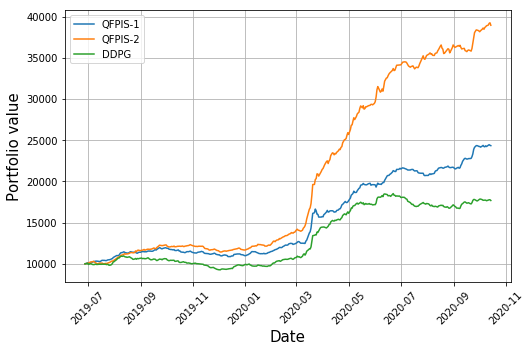

In [54]:
plt.figure()
plt.rcParams['figure.figsize'] = (8.0, 5.0)

plt.plot(date,wealths2, label='QFPIS-1')
plt.plot(date,wealths1, label='QFPIS-2')
plt.plot(date,wealths3, label='DDPG')

plt.grid(True)
plt.xlabel("Date",fontsize=15)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.ylabel("Portfolio value",fontsize=15)

plt.savefig("figure/backtest/backtest.png",dpi=600,bbox_inches = 'tight')